In [2]:
#Determine average descent/ascent speed of each spectral window

from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from em_apex_processing import *
from spectral_processing import *
import os
import warnings



### Load Files ###
fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)


#float_list = ['6667i']
#Loop through every float_id
big_w_store = [];
big_time_store = [];
float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    w_store = np.zeros(len(efr_files))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)
        
        overlap = 60
        nblock = 120
        fs = 1
        #A little hacky way to just reshape the depth timeseries
        [t_new, P_new] = reshape_u(mlt_efr, Pef, nblock, overlap, fs)
        w_temp = np.zeros(P_new.shape[0])
        for i in range(P_new.shape[0]):
            pstart = P_new[i, 0]
            tstart = t_new[i, 0]
            tend = t_new[i, -1]
            pend = P_new[i, -1]
            diffP = abs(pend-pstart)
            diffT = abs(tend-tstart)
            w_temp[i] = diffP/diffT
        w_store[counter] = np.nanmean(w_temp)
        time_store[counter]=np.nanmean(mlt_efr)
        
        if prof_num%2==0:
            #Then it's even and its an up profile
            up_down_store[counter] = 1
        else:
            up_down_store[counter] = 0
            
        counter+=1

    if float_id_counter==0:
        big_w_store=w_store
        big_time_store = time_store
        big_up_down_store = up_down_store
    else:
        big_w_store = np.append(big_w_store, w_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)


    float_id_counter+=1


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_56789/3145116783.py:85: RuntimeWarning: invalid value encountered in double_scalars
  w_temp[i] = diffP/diffT


In [9]:
w_temp

array([0.12484374, 0.12334737, 0.12026317, 0.12029887, 0.12135224,
       0.113943  , 0.10787345, 0.10992698, 0.1119175 , 0.11460686,
       0.12170644, 0.12813176])

In [10]:
np.abs(P_new[:, 0]-P_new[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

array([0.12484374, 0.12334737, 0.12026317, 0.12029887, 0.12135224,
       0.113943  , 0.10787345, 0.10992698, 0.1119175 , 0.11460686,
       0.12170644, 0.12813176])

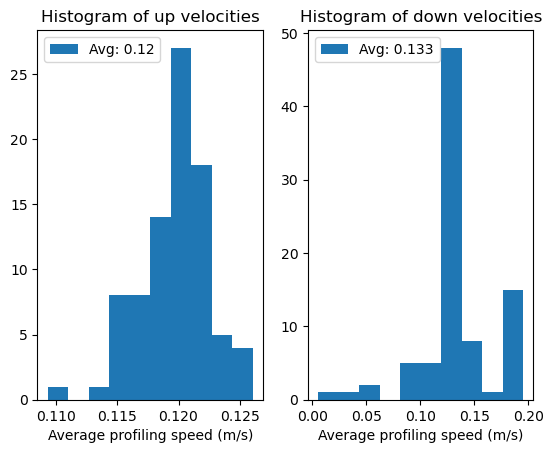

In [93]:
z_inds = np.where(big_w_store==0)
big_w_store[z_inds]=np.NaN

up_inds = np.where(big_up_down_store==1)
down_inds = np.where(big_up_down_store==0)



w_up_mean = np.nanmean(big_w_store[up_inds])
w_up_std = np.nanstd(big_w_store[up_inds])
w_down_mean = np.nanmean(big_w_store[down_inds])
w_down_std = np.nanstd(big_w_store[down_inds])

plt.figure()
plt.subplot(121)
plt.hist(big_w_store[up_inds], label="Avg: "+str(round(w_up_mean,3)))
plt.title("Histogram of up velocities")
plt.xlabel("Average profiling speed (m/s)")
plt.legend(loc='upper left')

plt.subplot(122)
plt.hist(big_w_store[down_inds], label="Avg: "+str(round(w_down_mean,3)))
plt.title("Histogram of down velocities")
plt.xlabel("Average profiling speed (m/s)")
plt.legend(loc='upper left')




In [75]:
#How do 

0.11981761391372332
0.13345408852176271


In [23]:
diffP = CTD["P"][0][0]-CTD["P"][0][-1]
diffT = abs(CTD["UXT"][0][0]-CTD["UXT"][0][-1])

In [25]:
diffP/diffT

0.11672685731132075

In [22]:
abs(CTD["UXT"][0][0]-CTD["UXT"][0][-1])

1219.0

In [62]:
prof_num

142

In [68]:
big_up_down_store.shape

(174,)

In [69]:
big_w_store.shape

(166,)